In [1]:
# Dependencies
import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr
import pandas as pd
import datetime
import json
import seaborn as sns
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from find_circle import make_circle
import matplotlib

sns.set_style("ticks",{"axes.facecolor": "white"})
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['axes.linewidth'] = 1

colour = "black"
plt.rcParams['text.color'] = colour
plt.rcParams['axes.labelcolor'] = colour
plt.rcParams['xtick.color'] = colour
plt.rcParams['ytick.color'] = colour

small_size = 7
medium_size = 8

plt.rc('font', size=medium_size)          
plt.rc('axes', titlesize=medium_size)    
plt.rc('axes', labelsize=medium_size)    
plt.rc('xtick', labelsize=small_size)    
plt.rc('ytick', labelsize=small_size)    
plt.rc('legend', fontsize=medium_size)    
plt.rc('figure', titlesize=medium_size) 
thresh_val = 30

dim = (512,512)
#dim=(256,256)

inner = True
tstr = "t0"

ksz_um = 10 # Kernel size for filters in um

In [2]:
# Go through each merged file and collect the resized image in a numpy array
def get_image_sequence(video_path,t_str, zstr_ar, img_dims):
    # Initialize the img numpy array
    img_seq = np.zeros((img_dims[0], img_dims[1], len(zstr_ar)), np.uint8)
    
    # Go over each z-stack image
    # Video capture object
    vidcap = cv2.VideoCapture(video_path)
    for zix in range(len(zstr_ar)):
        z_str = zstr_ar[zix]
        # Collect the path of the merged files
        try:
            success, frame = vidcap.read()
            
            # Convert to grayscale
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Add to image sequence array
            img_seq[:,:,zix] = frame_gray

        except Exception as e:
            print(success)
            print(f"Error! Cannot read video from path {video_path}")
        
    return img_seq

In [3]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        elif isinstance(obj, datetime.datetime):
            return str(obj)

        return json.JSONEncoder.default(self, obj)

In [4]:
# Read an image
video_path = "ImageStack.avi"
metadata = mf.collect_metadata("ImageStack_MetaData.xml", inner=inner)

cross_section_df = pd.DataFrame()

# Calculate kernel size in pixels for fixed length
xvoxel = metadata["dimensions"]["X"]["Voxel"]
yvoxel = metadata["dimensions"]["Y"]["Voxel"]
xnum = metadata["dimensions"]["X"]["NumberOfElements"]
ynum = metadata["dimensions"]["Y"]["NumberOfElements"]
w = metadata["tiles"]["xix_unique_ar"].size*xnum
h = metadata["tiles"]["yix_unique_ar"].size*ynum

ksz_px = ksz_um/xvoxel
# Make kernel size an odd integer
ksz_px = int(ksz_px/2)*2 + 1
print(f"width: {w} - height: {h}")
print(f"kernel um: {ksz_um} - kernel px: {ksz_px}")

# Go through each z and collect radius 
zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
zvoxel = -metadata["dimensions"]["Z"]["Voxel"]
zar_um = []
rar_um = []

# First, collect image sequence
# Find the number of digits
znum_digit = len(str(zsz-1))
# zstr for file path
zstr_holder = f"z%0{znum_digit}d"

# calculate z_strar for each z_str value
z_strar = np.zeros(zsz, dtype="<U6")
for zix in range(zsz):
    z_strar[zix] = zstr_holder % zix

print("\nCollecting image sequence")
img_seq = get_image_sequence(video_path, tstr, z_strar, dim)

print("Calculating radius for each z-section: ")

for zix in range(zsz):
    #print(f"{zix}/{zsz}", end="\r", flush=True)
    roi_image = img_seq[:, :, zix]
    blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
    #blurred_image = roi_image
    _, thresh_image = cv2.threshold(blurred_image, thresh_val, 255, cv2.THRESH_BINARY)

    zar_um.append(zix*zvoxel)

    ## Parse the positive points into 
    #  (yix,xix) = np.where(thresh_image>0)
    contours, hierarchy = cv2.findContours(np.uint8(thresh_image>0), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        points = np.vstack(contours).squeeze()
        if points.size > 2:
        #points = []
        #      for ix in range(len(xix)):
        #          points.append((xix[ix], yix[ix]))
            (x,y,rad) = make_circle(points)
            rar_um.append(rad*xvoxel*w/dim[0])
        else:
            rar_um.append(0)
    else:
        rar_um.append(0)

# Calculate height
r = np.array(rar_um)
z = np.array(zar_um)
idx, = np.where(r > 0)
surf = z[np.argmax(r)]
top = z[idx[-1]]
h = top-surf

#Print radius and height
print(np.amax(r))
print(h)

data = {"z(um)": z, "z-surf(um)": z-surf, "r(um)": r}
cross_section_df = pd.DataFrame(data)

width: 1024 - height: 1024
kernel um: 10 - kernel px: 3

Calculating radius for each z-section: 
1524.7423659703709
162.754


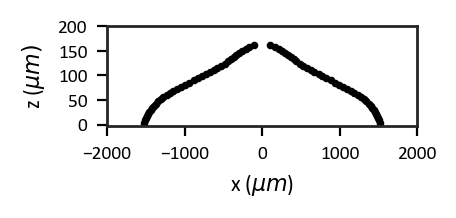

In [5]:
plt.rcParams["figure.figsize"] = (2,0.65)
fig, ax = plt.subplots(1,1)

htExp = cross_section_df.to_numpy()

r = np.asarray(cross_section_df["r(um)"])
z = np.asarray(cross_section_df["z-surf(um)"])

z = z[r>25]
r = r[r>25]

rPlot = np.concatenate((r,-r))
zPlot = np.concatenate((z,z))

rPlot = rPlot[zPlot>0]
zPlot = zPlot[zPlot>0]

ax.scatter(rPlot,zPlot, marker="o", s=3, color="black")
ax.tick_params(top=False, bottom=True, left=True, right=False,
               labelleft=True, labelbottom=True)
ax.set(xlabel="x ($\mu m$)", ylabel = "z ($\mu m)$");


ax.set_xticks(np.arange(-2000,2001,1000.0))
ax.set_yticks(np.arange(0,201,50.0))